In [1]:
import gym 
import collections
import numpy as np
import matplotlib.pyplot as plt
 
ENV_NAME = 'FrozenLake-v1'
GAMMA = 0.9 
ALPHA = 0.2 
TEST_EPISODES = 200

In [2]:
env = gym.make(ENV_NAME)
observation_space = env.observation_space.n
action_space = env.action_space.n

print(observation_space)
print(action_space)

16
4


/Users/mridul/anaconda3/envs/hgnn/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/mridul/anaconda3/envs/hgnn/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
class Agent_SARSA: 
    def __init__(self): 
        self.env = gym.make(ENV_NAME)
        self.state = self.env.reset()
        self.values = collections.defaultdict(float)
        
        self.train = True
        
        self.epsilon = 0.3
        self.min_epsilon = 0.01
        self.max_epsilon = 1.0
        self.epsilon_decay_rate = 0.005
        self.episodes = 0

    
    def sample_env(self): 
        """
        Inputs: 
            self: an agent
        Returns: 
            a tuple: (old_state, action,  reward, new_state, done)
        """
        # action = self.choose_action(self.state)
        new_state, reward, done, _ = self.env.step(self.action)
        return self.state, self.action, reward, new_state, done
    
    def choose_action(self, state): 
        """ 
        Inputs: 
            - self: an agent 
            - state: current state 
        Returns: 
            - next_a: the next action taken. 
        """
        action = self.env.action_space.sample()

        # updating action according to epsilon greedy
        if np.random.random() > self.epsilon:
            maximum_val = 0
            for s, a in self.values.keys():
                if s == state:
                    if self.values[(s,a)] >= maximum_val:
                        action = a
                        maximum_val = self.values[(s,a)]
        
        return action

    def value_update(self, s, a, r, next_s, next_a): 
        """ 
        Inputs: 
            - self: an agent 
            - s: state 
            - a: action 
            - r: reward 
            - next_s: next state
        Returns:
            - self.values[(s, a)]: the updated value of (s, a). 
        """
        return self.values[(s, a)] + ALPHA * (r + GAMMA * self.values[(next_s, next_a)] - self.values[(s, a)])
    
    def play_episode(self, env): 
        """ 
        Inputs: 
            - self: an agent 
            - env: the environment 
        Returns: 
            - total_reward: the total reward after playing an episode 
        """
        self.state = self.env.reset()
        total_reward = 0
        done = False
        self.action = self.choose_action(self.state)

        while not done:

            current_state, action, reward, new_state, done = self.sample_env()
            next_action = self.choose_action(new_state)

            # update q-value only while training
            if self.train:
                self.values[(current_state, action)] = self.value_update(current_state, action, reward, new_state, next_action)

            # updating the current state and action
            self.state = new_state
            self.action = next_action
            
            total_reward += reward

            # updating epsilon value
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.epsilon_decay_rate*self.episodes)
            
        self.episodes += 1
        return total_reward

In [4]:
train_episodes = 100000
sarsa = Agent_SARSA()
rewards = []
avg_test_reward = 0

for episode in range(train_episodes):
    sarsa.play_episode(env)

    # test the performance every 5000 episodes
    if (episode)  % 5000 == 0:
        reward = 0
        sarsa.train = False
        for _ in range(TEST_EPISODES): 
            reward += sarsa.play_episode(env)

        sarsa.train = True
        avg_test_reward = reward / TEST_EPISODES
        rewards.append(avg_test_reward)

    if avg_test_reward > 0.8:
        break


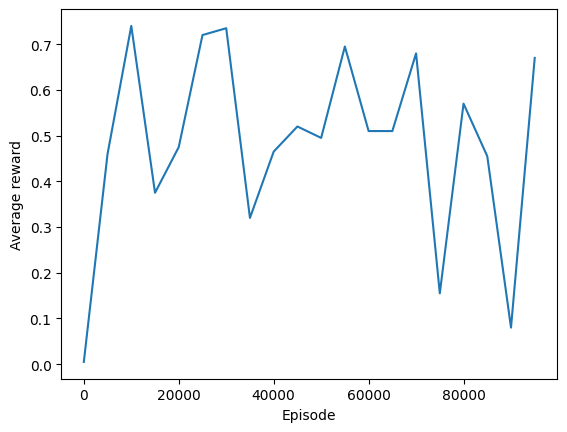

In [5]:

plt.plot(np.arange(len(rewards))*5000, rewards)
plt.ylabel('Average reward')
plt.xlabel('Episode')
plt.show()

In [6]:
class Agent_QLearning:
    def __init__(self):
        self.env = gym.make(ENV_NAME)
        self.state = self.env.reset()
        self.values = collections.defaultdict(float)

        self.train = True
        
        self.epsilon = 0.3
        self.min_epsilon = 0.01
        self.max_epsilon = 1.0
        self.epsilon_decay_rate = 0.0005
        self.episodes = 0
    
    def sample_env(self): 
        """
        Inputs: 
            - self: an agent 
        Returns: 
            - a tuple: (old_state, action, reward, new_state, done) 
        """

        # selecting action based on epsilon greedy
        action = self.env.action_space.sample()
        if np.random.random() > self.epsilon:
            _, action = self.best_value_and_action(self.state)
        else:
            action = self.env.action_space.sample()

        # doing the next step in the env
        new_state, reward, done, _ = self.env.step(action)
        return self.state, action, reward, new_state, done
    
        
    def best_value_and_action(self, state): 
        """
        Inputs: 
            - self: an agent 
            - state: current state
        Returns: 
            - best_value: the best value updated 
            - best_action: the best action taken. 
        """
        # getting the next best possible action and q-value for a given state
        best_value = 0
        best_action = 0
        for s, a in self.values.keys():
            if s == state:
                if self.values[(s,a)] >= best_value:
                    best_value = self.values[(s,a)]
                    best_action = a
        return best_value, best_action
    
    def value_update(self, s, a, r, next_s): 
        """
        Inputs: 
            - self: an agent 
            - s: state 
            - a: action 
            - r: reward 
            - next_s: next state
        Returns: 
            - self.values[(s, a)]: the updated value of (s, a).
        """
        # updating q-value
        return self.values[(s, a)] + ALPHA * (r + GAMMA * self.best_value_and_action(next_s)[0] - self.values[(s, a)])
        
        
    def play_episode(self, env):
        """ 
        Inputs: 
            - self: an agent 
            - env: the environment
        Returns:
            - total_reward: the total reward after playing an episode
        """
        
        self.state = self.env.reset()
        total_reward = 0
        done = False

        while not done:
            current_state, action, reward, new_state, done = self.sample_env()

            # update q-value only while training
            if self.train:
                self.values[(current_state, action)] = self.value_update(current_state, action, reward, new_state)

            # updating the current state
            self.state = new_state
            total_reward += reward

            #updating epsilon value
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.epsilon_decay_rate*self.episodes)
          
        self.episodes += 1
        return total_reward

In [ ]:
train_episodes = 100000
q_learning = Agent_QLearning()
rewards = []

for episode in range(train_episodes):
    q_learning.play_episode(env)

    # test the performance every 5000 episodes
    if (episode)  % 5000 == 0:
        reward = 0
        q_learning.train = False
        for _ in range(TEST_EPISODES): 
            reward += q_learning.play_episode(env)

        q_learning.train = True
        avg_test_reward = reward / TEST_EPISODES
        rewards.append(avg_test_reward)

    if avg_test_reward > 0.8:
        break


In [ ]:
plt.plot(np.arange(len(rewards))*5000, rewards)
plt.ylabel('Average reward')
plt.xlabel('Episode')
plt.show()